In [1]:
# https://towardsdatascience.com/bert-for-dummies-step-by-step-tutorial-fb90890ffe03

import os
import pickle
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout
from tensorflow.keras.models import Model, Sequential
from nltk.translate.bleu_score import corpus_bleu

In [18]:
DATA_DIR="data"

# load Pickle file 
def load_ds(fname=os.path.join(DATA_DIR,'/atis.train.pkl'), verbose=True):
    with open(fname, 'rb') as stream:
        ds,dicts = pickle.load(stream)
    if verbose:
      print('Done  loading: ', fname)
      print('      samples: {:4d}'.format(len(ds['query'])))
      print('   vocab_size: {:4d}'.format(len(dicts['token_ids'])))
      print('   slot count: {:4d}'.format(len(dicts['slot_ids'])))
      print(' intent count: {:4d}'.format(len(dicts['intent_ids'])))
    return ds,dicts
  
# convert Pickle file to arrays
def load_atis(filename, add_start_end_token=False, verbose=True):
    train_ds, dicts = load_ds(os.path.join(DATA_DIR,filename), verbose)
    t2i, s2i, in2i = map(dicts.get, ['token_ids', 'slot_ids','intent_ids'])
    i2t, i2s, i2in = map(lambda d: {d[k]:k for k in d.keys()}, [t2i,s2i,in2i])
    query, slots, intent =  map(train_ds.get, ['query', 'slot_labels', 'intent_labels'])

    if add_start_end_token:
        i2s[178] = 'BOS'
        i2s[179] = 'EOS'
        s2i['BOS'] = 178
        s2i['EOS'] = 179

    input_tensor = []
    target_tensor = []
    query_data = []
    intent_data = []
    slot_data = []
    to_show = np.random.randint(0, len(query)-1, 5)
    for i in range(len(query)):
        input_tensor.append(query[i])
        slot_text = []
        slot_vector = []
        for j in range(len(query[i])):
            slot_text.append(i2s[slots[i][j]])
            slot_vector.append(slots[i][j])
        if add_start_end_token:
            slot_text[0] = 'BOS'
            slot_vector[0] = 178
            slot_text[-1] = 'EOS'
            slot_vector[-1]= 179
        target_tensor.append(slot_vector)
        q = ' '.join(map(i2t.get, query[i]))
        query_data.append(q.replace('BOS', '').replace('EOS',''))
        intent_data.append(i2in[intent[i][0]])
        slot = ' '.join(slot_text)
        slot_data.append(slot[1:-1])
        if i in to_show and verbose:
          print('Query text:', q)
          print('Query vector: ', query[i])
          print('Intent label: ', i2in[intent[i][0]])
          print('Slot text: ', slot)
          print('Slot vector: ', slot_vector)
          print('*'*74)
    query_data = np.array(query_data)
    intent_data = np.array(intent_data)
    slot_data = np.array(slot_data)
    intent_data_label = np.array(intent).flatten()
    return t2i, s2i, in2i, i2t, i2s, i2in, input_tensor, target_tensor, query_data, intent_data, intent_data_label, slot_data

# load ATIS training dataset
t2i_train, s2i_train, in2i_train, i2t_train, i2s_train, i2in_train, \
input_tensor_train, target_tensor_train, \
query_data_train, intent_data_train, intent_data_label_train, slot_data_train = load_atis('atis.train.pkl')

# load ATIS testing dataset
t2i_test, s2i_test, in2i_test, i2t_test, i2s_test, i2in_test, \
input_tensor_test, target_tensor_test, \
query_data_test, intent_data_test, intent_data_label_test, slot_data_test = load_atis('atis.test.pkl')
  

Done  loading:  data\atis.train.pkl
      samples: 4978
   vocab_size:  943
   slot count:  129
 intent count:   26
Query text: BOS flights from pittsburgh to baltimore arriving between 4 and 5 pm EOS
Query vector:  [178 429 444 682 851 247 238 259 102 215 121 689 179]
Intent label:  flight
Slot text:  O O O B-fromloc.city_name O B-toloc.city_name O O B-arrive_time.start_time O B-arrive_time.end_time I-arrive_time.end_time O
Slot vector:  [128, 128, 128, 48, 128, 78, 128, 128, 13, 128, 10, 86, 128]
**************************************************************************
Query text: BOS list all american airlines from milwaukee to phoenix on saturday EOS
Query vector:  [178 549 207 212 200 444 595 851 681 654 740 179]
Intent label:  flight
Slot text:  O O O B-airline_name I-airline_name O B-fromloc.city_name O B-toloc.city_name O B-depart_date.day_name O
Slot vector:  [128, 128, 128, 2, 83, 128, 48, 128, 78, 128, 26, 128]
***************************************************************

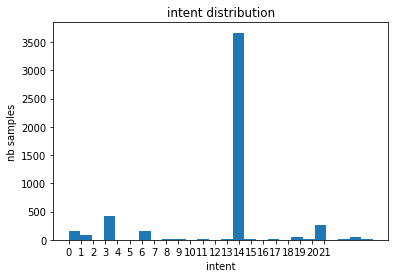

In [19]:
labels = intent_data_label_train
plt.hist(labels, bins=26)
plt.xlabel('intent')
plt.ylabel('nb samples')
plt.title('intent distribution')
plt.xticks(np.arange(len(np.unique(labels))));

In [4]:
pd.set_option('display.max_colwidth', -1)
df = pd.DataFrame({'query': query_data_train, 'intent': intent_data_train, 'slot filling': slot_data_train})

df_small = pd.DataFrame(columns=['query','intent','slot filling'])
j = 0
for i in df.intent.unique():
  df_small.loc[j] = df[df.intent==i].iloc[0]
  j = j+1
  
df_small

,query,intent,slot filling
0,i want to fly from boston at 838 am and arrive in denver at 1110 in the morning,flight,O O O O O B-fromloc.city_name O B-depart_time.time I-depart_time.time O O O B-toloc.city_name O B-arrive_time.time O O B-arrive_time.period_of_day
1,what is the arrival time in san francisco for the 755 am flight leaving washington,flight_time,O O O B-flight_time I-flight_time O B-fromloc.city_name I-fromloc.city_name O O B-depart_time.time I-depart_time.time O O B-fromloc.city_name
2,cheapest airfare from tacoma to orlando,airfare,B-cost_relative O O B-fromloc.city_name O B-toloc.city_name
3,what kind of aircraft is used on a flight from cleveland to dallas,aircraft,O O O O O O O O O O B-fromloc.city_name O B-toloc.city_name
4,what kind of ground transportation is available in denver,ground_service,O O O O O O O O B-city_name
5,what 's the airport at orlando,airport,O O O O O B-city_name
6,which airline serves denver pittsburgh and atlanta,airline,O O O B-fromloc.city_name B-fromloc.city_name O B-fromloc.city_name
7,how far is it from orlando airport to orlando,distance,O O O O O B-fromloc.airport_name I-fromloc.airport_name O B-toloc.city_name
8,what is fare code h,abbreviation,O O O O B-fare_basis_code
9,how much does the limousine service cost within pittsburgh,ground_fare,O O O O B-transport_type O O O B-city_name


In [5]:
i2s_train_values = list(i2s_train.values())
df3 = pd.DataFrame()
for i in range(7):
  df3[str(i)] = i2s_train_values[i*15:(i+1)*15]
df3

,0,1,2,3,4,5,6
0,B-aircraft_code,B-arrive_time.time_relative,B-depart_date.year,B-flight_time,B-return_date.day_name,B-today_relative,I-arrive_time.time_relative
1,B-airline_code,B-booking_class,B-depart_time.end_time,B-fromloc.airport_code,B-return_date.day_number,B-toloc.airport_code,I-city_name
2,B-airline_name,B-city_name,B-depart_time.period_mod,B-fromloc.airport_name,B-return_date.month_name,B-toloc.airport_name,I-class_type
3,B-airport_code,B-class_type,B-depart_time.period_of_day,B-fromloc.city_name,B-return_date.today_relative,B-toloc.city_name,I-cost_relative
4,B-airport_name,B-compartment,B-depart_time.start_time,B-fromloc.state_code,B-return_time.period_mod,B-toloc.country_name,I-depart_date.day_name
5,B-arrive_date.date_relative,B-connect,B-depart_time.time,B-fromloc.state_name,B-return_time.period_of_day,B-toloc.state_code,I-depart_date.day_number
6,B-arrive_date.day_name,B-cost_relative,B-depart_time.time_relative,B-meal,B-round_trip,B-toloc.state_name,I-depart_date.today_relative
7,B-arrive_date.day_number,B-day_name,B-economy,B-meal_code,B-state_code,B-transport_type,I-depart_time.end_time
8,B-arrive_date.month_name,B-day_number,B-fare_amount,B-meal_description,B-state_name,I-airline_name,I-depart_time.period_of_day
9,B-arrive_date.today_relative,B-days_code,B-fare_basis_code,B-mod,B-stoploc.airport_code,I-airport_name,I-depart_time.start_time


In [6]:
def max_length(tensor):
    return max(len(t) for t in tensor)

# Helper function to pad the query tensor and slot (target) tensor to the same length. 
# Also creates a tensor for teacher forcing.
def create_tensors(input_tensor, target_tensor, nb_sample=9999999, max_len=0):
    len_input, len_target  = max_length(input_tensor), max_length(target_tensor)
    len_input = max(len_input,max_len)
    len_target = max(len_target,max_len)
    

    # Padding the input and output tensor to the maximum length
    input_data = tf.keras.preprocessing.sequence.pad_sequences(input_tensor, 
                                                                 maxlen=len_input,
                                                                 padding='post')

    teacher_data = tf.keras.preprocessing.sequence.pad_sequences(target_tensor, 
                                                                  maxlen=len_target , 
                                                                  padding='post')
    
    target_data = [[teacher_data[n][i+1] for i in range(len(teacher_data[n])-1)] for n in range(len(teacher_data))]
    target_data = tf.keras.preprocessing.sequence.pad_sequences(target_data, maxlen=len_target, padding="post")
    target_data = target_data.reshape((target_data.shape[0], target_data.shape[1], 1))
    
    nb = len(input_data)
    p = np.random.permutation(nb)
    input_data = input_data[p]
    teacher_data = teacher_data[p]
    target_data = target_data[p]

    return input_data[:min(nb_sample, nb)], teacher_data[:min(nb_sample, nb)], target_data[:min(nb_sample, nb)], len_input, len_target 
           
input_data_train, teacher_data_train, target_data_train, len_input_train, len_target_train  = create_tensors(input_tensor_train, target_tensor_train)
input_data_test, teacher_data_test, target_data_test, len_input_test, len_target_test  = create_tensors(input_tensor_test, target_tensor_test, max_len=len_input_train)

print('Tensors created.')

Tensors created.


In [7]:
def get_vocab_size(t2i_train, t2i_test, s2i_train, s2i_test):
    vocab_in_size = len({**t2i_train, **t2i_test})
    vocab_out_size = len({**s2i_train, **s2i_test})
    return vocab_in_size, vocab_out_size
  
vocab_in_size, vocab_out_size = get_vocab_size(t2i_train, t2i_test, s2i_train, s2i_test)
vocab_in_size, vocab_out_size

(943, 129)

In [8]:
from keras.utils import to_categorical

# BUFFER_SIZE = len(input_data_train)
BATCH_SIZE = 64
embedding_dim = 256
units = 1024
nb_labels=26

intent_data_label_cat_train = to_categorical(intent_data_label_train, num_classes=nb_labels)
print(intent_data_label_cat_train.shape)

(4978, 26)


Using TensorFlow backend.


In [9]:
model_lstm = Sequential()
model_lstm.add(Embedding(vocab_in_size, embedding_dim, input_length=len_input_train))
model_lstm.add(LSTM(units))
model_lstm.add(Dense(nb_labels, activation='softmax'))
model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.summary()

history_lstm = model_lstm.fit(input_data_train, intent_data_label_cat_train, 
                              epochs=10,batch_size=BATCH_SIZE)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 48, 256)           241408    
_________________________________________________________________
lstm (LSTM)                  (None, 1024)              5246976   
_________________________________________________________________
dense (Dense)                (None, 26)                26650     
Total params: 5,515,034
Trainable params: 5,515,034
Non-trainable params: 0
_________________________________________________________________
Train on 4978 samples
Epoch 1/10
4978/4978 [==============================] - 5s 992us/sample - loss: 1.2777 - accuracy: 0.7268
Epoch 2/10
4978/4978 [==============================] - 2s 415us/sample - loss: 1.1448 - accuracy: 0.7364
Epoch 3/10
4978/4978 [==============================] - 2s 418us/sample - loss: 1.1442 - accuracy: 0.7364
Epoch 4/10
4978/4978 [==============

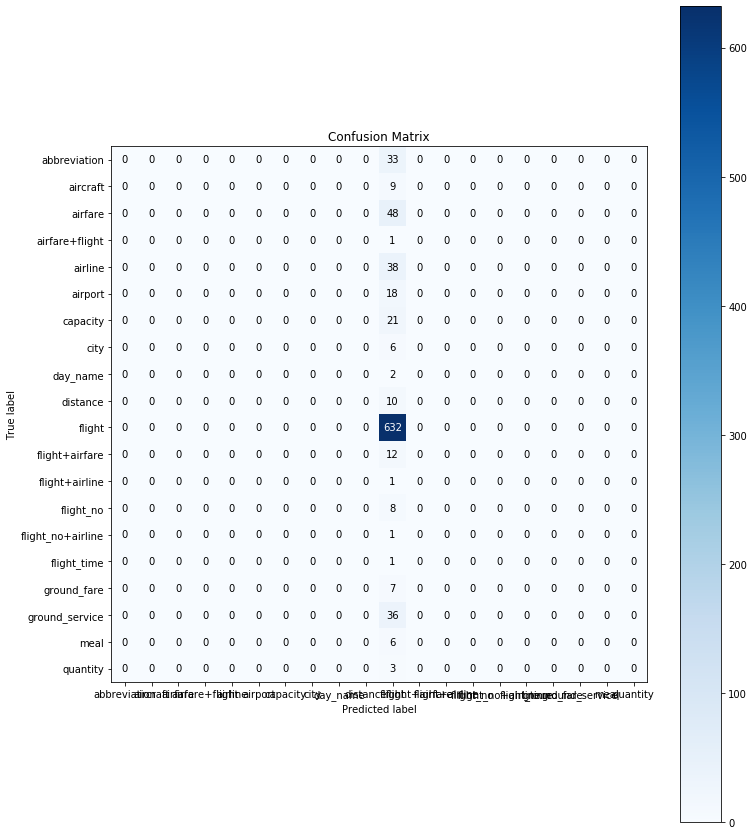

In [11]:
import scikitplot as skplt

def preprocess_query(w):
    w = w.rstrip().strip().lower()
    w = "BOS " + w + " EOS"
    return w
  
# Converts the given query (just a string) into a vector of word IDs
# using the language specified. This can be used for either the input (query)
# or target (slot)
# Output is 1-D: [timesteps/words]
def query_to_vector(query, len_input=len_input_train, t2i=t2i_train):
    pre = preprocess_query(query)
    vec = np.zeros(len_input)
    query_list = [t2i[s] for s in pre.split(' ')]
    for i,w in enumerate(query_list):
        vec[i] = w
    return vec

def predict_intent(input_query, model=model_lstm, i2in=i2in_test, verbose=False):
  sv = query_to_vector(input_query)
  sv = sv.reshape(1,len(sv))
  intent_idx = np.argmax(model.predict(sv), axis=1)[0]
  intent_label = i2in[intent_idx]
  if verbose:
    print(intent_label)
  return intent_label, intent_idx

def evaluate_intent(queries, true_intents, model):
  predicted_intents = []
  for q in queries:
    intent_label, intent_idx = predict_intent(q, model)
    predicted_intents.append(intent_label)
  skplt.metrics.plot_confusion_matrix(true_intents, predicted_intents, figsize=(12,15))
  
true_intents = [i2in_test[i] for i in intent_data_label_test]
evaluate_intent(query_data_test, true_intents, model_lstm)

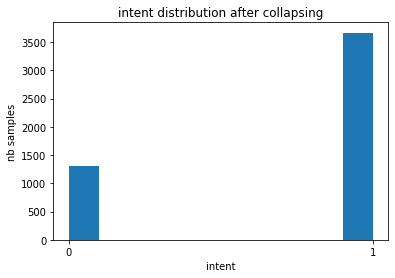

In [25]:
labels1 = np.copy(labels)
labels1[labels==14] = 1
labels1[labels!=14] = 0

plt.hist(labels1)
plt.xlabel('intent')
plt.ylabel('nb samples')
plt.title('intent distribution after collapsing')
plt.xticks(np.arange(len(np.unique(labels1))));

In [26]:
model_lstm2 = Sequential()
model_lstm2.add(Embedding(vocab_in_size, embedding_dim, input_length=len_input_train))
model_lstm2.add(LSTM(units))
model_lstm2.add(Dense(1, activation='sigmoid'))
model_lstm2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history_lstm2 = model_lstm2.fit(input_data_train, labels1, epochs=10, batch_size=BATCH_SIZE)

Train on 4978 samples
Epoch 1/10
4978/4978 [==============================] - 4s 839us/sample - loss: 0.6026 - accuracy: 0.7288
Epoch 2/10
4978/4978 [==============================] - 2s 396us/sample - loss: 0.5798 - accuracy: 0.7362
Epoch 3/10
4978/4978 [==============================] - 2s 389us/sample - loss: 0.5793 - accuracy: 0.7364
Epoch 4/10
4978/4978 [==============================] - 2s 397us/sample - loss: 0.5795 - accuracy: 0.7364
Epoch 5/10
4978/4978 [==============================] - 2s 405us/sample - loss: 0.5805 - accuracy: 0.7364
Epoch 6/10
4978/4978 [==============================] - 2s 402us/sample - loss: 0.5776 - accuracy: 0.7364
Epoch 7/10
4978/4978 [==============================] - 2s 403us/sample - loss: 0.5778 - accuracy: 0.7364
Epoch 8/10
4978/4978 [==============================] - 2s 400us/sample - loss: 0.6069 - accuracy: 0.7218
Epoch 9/10
4978/4978 [==============================] - 2s 404us/sample - loss: 0.5824 - accuracy: 0.7364
Epoch 10/10
4978/4978 [=

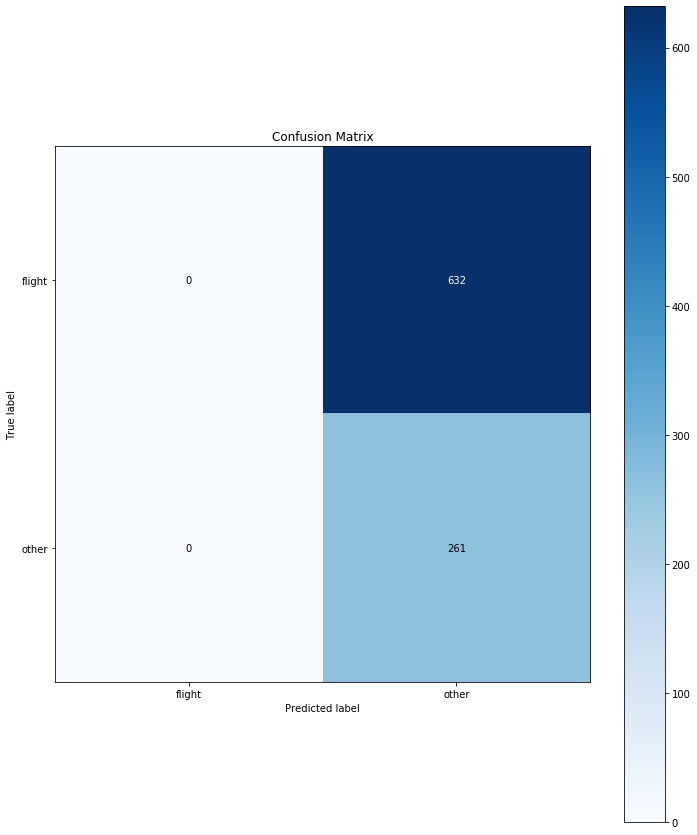

In [27]:
true_intents = ['flight' if i==14 else 'other' for i in intent_data_label_test]
predicted_intents = []
for q in query_data_test:
    intent_label, intent_idx = predict_intent(q, model_lstm2)
    predicted_intents.append('flight' if intent_idx==1 else 'other')
    
skplt.metrics.plot_confusion_matrix(true_intents, predicted_intents, figsize=(12,15))